In [10]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
sys.path.append(os.path.dirname(os.getcwd())) # Needed to load all the modules in the parent directory
from AnalysisCommons.Run import INFO, WARNING, ERROR, DEBUG, Logger
INFO.log("Adding the following path to sys.path:", os.path.dirname(os.getcwd()))
Logger.LOGLEVEL = 3 # Set the log level

INFO: Adding the following path to sys.path: /Users/user/Documents/HEP/VBF-Analysis


# CLs method implementation
You have to activate conda Stats environment

In [11]:
import pyhf
import numpy as np
import matplotlib.pyplot as plt
from pyhf.contrib.viz import brazil
import pandas as pd

def extract_signal_points(pandas_df, mass_limit):
    # Extract all the SignalX names from the pandas dataframe
    columns = pandas_df.columns
    signal_names = [col for col in columns if col.startswith('Signal')]
    # Filter the signal names based on the mass limit
    filtered_signal_names = []
    for name in signal_names:
        mass = int(name.replace('Signal',''))
        if mass <= mass_limit:
            filtered_signal_names.append(name)

    INFO.log("Considering the following signals:")
    for isignal in filtered_signal_names:
        INFO.log(" - ", isignal)
    return filtered_signal_names

def construct_signal_array(pandas_df):
    signal_names = extract_signal_points(pandas_df, mass_limit=1100)
    signal_array = []
    for signal_sample in signal_names:
        signal_array.append(np.array(pandas_df[signal_sample]))

    return np.array(signal_array)

def merge_channels(channel_one_csv : str , channel_two_csv : str = None, method : str ='extend'):
    
    if method not in ['merge', 'extend']:
        raise ValueError("Method must be either 'merge' or 'extend'")
    
    # Load the first channel
    pd1 = pd.read_csv(channel_one_csv)
    bkg_array1 = np.array(pd1['Background'])
    bkg_error_array1 = np.array(pd1['BackgroundError'])
    signal_1_array = construct_signal_array(pd1)
    signal_names = extract_signal_points(pd1, mass_limit=1100)

    if channel_two_csv is None:
        # Create a dataframe with names of columns and data
        result_dic = {
            'Background': bkg_array1,
            'BackgroundError': bkg_error_array1,
        }
        for i, signal_name in enumerate(signal_names):
            result_dic[signal_name] = signal_1_array[i]
        result_df = pd.DataFrame(result_dic)
        result_df.to_csv('cls_inputs.csv', index=False)

    else:
        # Load the second channel
        pd2 = pd.read_csv(channel_two_csv)
        bkg_array2 = np.array(pd2['Background'])
        bkg_error_array2 = np.array(pd2['BackgroundError'])
        signal_2_array = construct_signal_array(pd2)

        # Merge the two channels
        if method == 'merge':
            bkg_array = bkg_array1 + bkg_array2
            bkg_error_array = np.sqrt(bkg_error_array1**2 + bkg_error_array2**2)
            signal_array = signal_1_array + signal_2_array

            # Save the merged data to a new CSV file
            result_dic = {
                'Background': bkg_array,
                'BackgroundError': bkg_error_array,
            }
            for i, signal_name in enumerate(signal_names):
                result_dic[signal_name] = signal_array[i]
            result_df = pd.DataFrame(result_dic)
            result_df.to_csv('cls_inputs.csv', index=False)

        elif method == 'extend':
            bkg_array = np.concatenate((bkg_array1, bkg_array2))
            bkg_error_array = np.concatenate((bkg_error_array1, bkg_error_array2))
            signal_array = np.concatenate((signal_1_array, signal_2_array), axis=1)

            # Save the extended data to a new CSV file
            result_dic = {
                'Background': bkg_array,
                'BackgroundError': bkg_error_array,
            }
            for i, signal_name in enumerate(signal_names):
                result_dic[signal_name] = signal_array[i]
            result_df = pd.DataFrame(result_dic)
            result_df.to_csv('cls_inputs.csv', index=False)


pyhf.set_backend("numpy")

channels_to_fit = ['results/CLsInputs_test.csv', None]
# Merge the channels
merge_channels(channels_to_fit[0], channels_to_fit[1], method='extend')
plot_title = 'TauTau'

pd = pd.read_csv('cls_inputs.csv')
bkg_array = np.array(pd['Background'])
bkg_error_array = np.array(pd['BackgroundError'])

INFO: Considering the following signals: 
INFO:  -  Signal200
INFO:  -  Signal250
INFO:  -  Signal300
INFO:  -  Signal350
INFO:  -  Signal400
INFO:  -  Signal450
INFO:  -  Signal500
INFO:  -  Signal550
INFO:  -  Signal600
INFO:  -  Signal650
INFO:  -  Signal700
INFO:  -  Signal750
INFO:  -  Signal800
INFO:  -  Signal850
INFO:  -  Signal900
INFO:  -  Signal950
INFO:  -  Signal1000
INFO: Considering the following signals: 
INFO:  -  Signal200
INFO:  -  Signal250
INFO:  -  Signal300
INFO:  -  Signal350
INFO:  -  Signal400
INFO:  -  Signal450
INFO:  -  Signal500
INFO:  -  Signal550
INFO:  -  Signal600
INFO:  -  Signal650
INFO:  -  Signal700
INFO:  -  Signal750
INFO:  -  Signal800
INFO:  -  Signal850
INFO:  -  Signal900
INFO:  -  Signal950
INFO:  -  Signal1000


In [48]:
signal_names = extract_signal_points(pd, mass_limit=1100)
expected_limits = {}
for signal_name in signal_names:
    INFO.log("Calculating limits for signal:", signal_name)
    # Declare model
    model = pyhf.simplemodels.uncorrelated_background(
        signal = np.array(pd[signal_name]) ,
        bkg = bkg_array,
        bkg_uncertainty = bkg_error_array,)
    # Set data to bkg expected for the time being
    data = list(bkg_array) + model.config.auxdata
        
    obs_limit, exp_limits = pyhf.infer.intervals.upper_limits.toms748_scan( data, model, bounds_low = 0, bounds_up = 10, par_bounds=[(0, 100)])
        

    expected_limits[signal_name] = exp_limits
    INFO.log(" - Expected limits calculated for signal:", signal_name)
    INFO.log("   -> Limits:", exp_limits)

INFO: Considering the following signals: 
INFO:  -  Signal200
INFO:  -  Signal250
INFO:  -  Signal300
INFO:  -  Signal350
INFO:  -  Signal400
INFO:  -  Signal450
INFO:  -  Signal500
INFO:  -  Signal550
INFO:  -  Signal600
INFO:  -  Signal650
INFO:  -  Signal700
INFO:  -  Signal750
INFO:  -  Signal800
INFO:  -  Signal850
INFO:  -  Signal900
INFO:  -  Signal950
INFO:  -  Signal1000
INFO: Calculating limits for signal: Signal200
INFO:  - Expected limits calculated for signal: Signal200
INFO:    -> Limits: [array(0.01743239), array(0.02436297), array(0.03598712), array(0.0545384), array(0.08064885)]
INFO: Calculating limits for signal: Signal250
INFO:  - Expected limits calculated for signal: Signal250
INFO:    -> Limits: [array(0.04885188), array(0.06753461), array(0.09834855), array(0.14680348), array(0.21437681)]
INFO: Calculating limits for signal: Signal300
INFO:  - Expected limits calculated for signal: Signal300
INFO:    -> Limits: [array(0.0780025), array(0.10854258), array(0.15985

In [46]:
expected_limits

{'Signal200': [array(0.01743239),
  array(0.02436297),
  array(0.03598712),
  array(0.0545384),
  array(0.08064885)],
 'Signal250': [array(0.04885188),
  array(0.06753461),
  array(0.09834855),
  array(0.14680348),
  array(0.21437681)],
 'Signal300': [array(0.0780025),
  array(0.10854258),
  array(0.15985229),
  array(0.24247396),
  array(0.36038318)],
 'Signal350': [array(0.15688355),
  array(0.21697039),
  array(0.31658302),
  array(0.47470138),
  array(0.69786748)],
 'Signal400': [array(0.19353104),
  array(0.27233768),
  array(0.40676929),
  array(0.62542805),
  array(0.938443)],
 'Signal450': [array(0.24520164),
  array(0.34659063),
  array(0.52125541),
  array(0.80869218),
  array(1.22460884)],
 'Signal500': [array(0.38421874),
  array(0.53445217),
  array(0.7874428),
  array(1.19688673),
  array(1.78552938)],
 'Signal550': [array(0.50377911),
  array(0.70285687),
  array(1.04005099),
  array(1.58786032),
  array(2.376665)],
 'Signal600': [array(0.60902706),
  array(0.85631373),


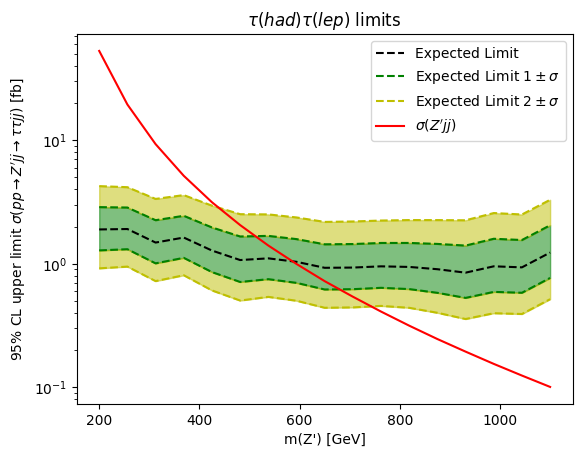

In [51]:
from AnalysisCommons.Constants import ZPRIME_XSEC
xsec_list = 1000*np.array(ZPRIME_XSEC[:len(signal_names)]) # in fb

expected_line = []
sigma_p1_line = []
sigma_p2_line = []
sigma_m1_line = []
sigma_m2_line = []

for i in signal_names:
    expected_line.append(float(expected_limits[i][2]))
    sigma_p1_line.append(float(expected_limits[i][3]))
    sigma_p2_line.append(float(expected_limits[i][4]))
    sigma_m1_line.append(float(expected_limits[i][1]))
    sigma_m2_line.append(float(expected_limits[i][0]))

expected_line = np.array(xsec_list)*np.array(expected_line)
sigma_p1_line = np.array(xsec_list)*np.array(sigma_p1_line)
sigma_p2_line = np.array(xsec_list)*np.array(sigma_p2_line)
sigma_m1_line = np.array(xsec_list)*np.array(sigma_m1_line)
sigma_m2_line = np.array(xsec_list)*np.array(sigma_m2_line)

x_axis = np.linspace(200, 1100, 17)
fig, ax = plt.subplots()
ax.plot(x_axis,expected_line,'k--',label='Expected Limit')
ax.plot(x_axis,sigma_p1_line,'g--',label=r'Expected Limit $1\pm\sigma$')
ax.plot(x_axis,sigma_m1_line,'g--')
ax.plot(x_axis,sigma_p2_line,'y--',label=r'Expected Limit $2\pm\sigma$')
ax.plot(x_axis,sigma_m2_line,'y--')
ax.plot(x_axis,xsec_list,'r-',label=r"$\sigma( Z'jj )$")
ax.set_title(plot_title)

ax.legend()

ax.set_title(r"$\tau (had) \tau (lep)$ limits")

ax.set_yscale('log')
ax.set_xlabel(r"m(Z') [GeV]")
ax.set_ylabel(r"95% CL upper limit $\sigma(pp\to Z'jj\to \tau\tau jj)$ [fb]")

ax.fill_between(x_axis, sigma_m1_line, sigma_p1_line, alpha=0.5, color='g')
ax.fill_between(x_axis, sigma_m2_line, sigma_m1_line, alpha=0.5, color='y')
ax.fill_between(x_axis, sigma_p1_line, sigma_p2_line, alpha=0.5, color='y')
xsec_list

fig.savefig('CLsLimits.pdf')

# 

/var/folders/vz/9jwsmzpn0d7g_dzz8znp1mzw0000gp/T/ipykernel_5013/321161548.py:12: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


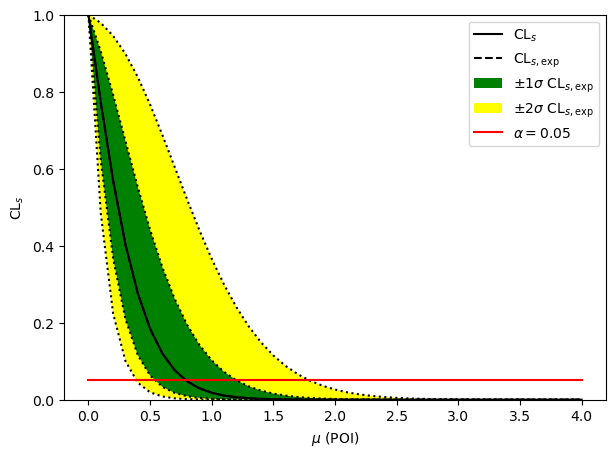

In [87]:
poi_vals = np.linspace(0, 4.0, 41)
results = [
    pyhf.infer.hypotest(
        test_poi, data, model, test_stat="qtilde", return_expected_set=True
    )
    for test_poi in poi_vals
]

fig, ax = plt.subplots()
fig.set_size_inches(7, 5)
brazil.plot_results(poi_vals, results, ax=ax)
fig.show()